In [1]:
# AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=512
n_units=512
l2Regularizer=1e-09
kernel_size1 = 2
kernel_size2 = 5
n_grid = 101
strides = 2
input_size = 49

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out')

In [7]:
origin = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin_data)
folders = [file for file in folders_orig if file.startswith('airfoil')]

In [9]:
coord_df = pd.DataFrame()
counter = 1
for i in range(1, 134):
    coord_file_name = origin_coord + "\\airfoil" + str(i) + "\\airfoilOut"+ str(i) + ".txt"
    data = pd.read_csv(coord_file_name, sep = ",", header=None)
    while counter < 17:
        coord_df = pd.concat([coord_df, data], axis=0)
        counter += 1
    counter=1

In [10]:
coord_np = coord_df.iloc[:, :].values

In [11]:
coord = coord_np.reshape((len(folders), 16, 2, 50))

In [12]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [13]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [14]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [15]:
y = y.reshape((133, 16, 2, 1))

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [17]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [18]:
geometry.shape

(2128, 1)

In [19]:
geometry = geometry.reshape((133, 16, 1))

In [20]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(coord, aa, geometry, y, test_size=0.3, random_state=1)

In [21]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [23]:
input_coord = tf.keras.Input(shape=(2, 50, 1))
input_alpha = tf.keras.Input(shape=(1,1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer')(input_coord)
x_ = tf.keras.layers.MaxPooling2D((1,2))(x_conv)
reshape1 = tf.keras.layers.Flatten()(x_)
reshape2 = tf.keras.layers.Reshape((1,))(input_alpha)
x_concat = tf.keras.layers.Concatenate(axis=1)([reshape1, reshape2])

x_ = tf.keras.layers.Dense(units=n_units, activation='relu', name='firstHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_concat)
x_ = tf.keras.layers.Dense(units=400, activation='relu', name='secondHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)
x_ = tf.keras.layers.Dense(units=300, activation='relu', name='thirdHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)
x_ = tf.keras.layers.Dense(units=200, activation='relu', name='fourthHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='fifthHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)
output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayerSensor')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-I
model = tf.keras.Model([input_coord, input_alpha], output_image)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 50, 1)]   0           []                               
                                                                                                  
 Conv2DLayer (Conv2D)           (None, 1, 25, 512)   5632        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 12, 512)   0           ['Conv2DLayer[0][0]']            
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                              

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
start = datetime.datetime.now()
history = model.fit([x_train,aa_train], y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
47/47 [==============================] - 3s 6ms/step - loss: 0.0310 - rmse: 0.1760
Epoch 2/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0120 - rmse: 0.1096
Epoch 3/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0104 - rmse: 0.1019
Epoch 4/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0099 - rmse: 0.0992
Epoch 5/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0980
Epoch 6/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0086 - rmse: 0.0925
Epoch 7/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0096 - rmse: 0.0979
Epoch 8/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0094 - rmse: 0.0969
Epoch 9/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0084 - rmse: 0.0919
Epoch 10/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0083 - rmse: 0.0912
Epoch 11/5000
47/47 [==================

47/47 [==============================] - 0s 8ms/step - loss: 0.0050 - rmse: 0.0705
Epoch 86/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0052 - rmse: 0.0724
Epoch 87/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0051 - rmse: 0.0713
Epoch 88/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0045 - rmse: 0.0673
Epoch 89/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0044 - rmse: 0.0667
Epoch 90/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0049 - rmse: 0.0699
Epoch 91/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0046 - rmse: 0.0676
Epoch 92/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0042 - rmse: 0.0650
Epoch 93/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0045 - rmse: 0.0674
Epoch 94/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0042 - rmse: 0.0647
Epoch 95/5000
47/47 [=======================

47/47 [==============================] - 0s 7ms/step - loss: 0.0042 - rmse: 0.0648
Epoch 169/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0036 - rmse: 0.0601
Epoch 170/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0033 - rmse: 0.0573
Epoch 171/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0551
Epoch 172/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0039 - rmse: 0.0627
Epoch 173/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 0.0581
Epoch 174/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0033 - rmse: 0.0572
Epoch 175/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0590
Epoch 176/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0544
Epoch 177/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0033 - rmse: 0.0573
Epoch 178/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0035 - rmse: 0.0590
Epoch 252/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0028 - rmse: 0.0527
Epoch 253/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0451
Epoch 254/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0462
Epoch 255/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0451
Epoch 256/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0405
Epoch 257/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0452
Epoch 258/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0433
Epoch 259/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0464
Epoch 260/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0474
Epoch 261/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0028 - rmse: 0.0524
Epoch 335/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0454
Epoch 336/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0458
Epoch 337/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0448
Epoch 338/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0415
Epoch 339/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0415
Epoch 340/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0346
Epoch 341/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0382
Epoch 342/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0353
Epoch 343/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.8342e-04 - rmse: 0.0312
Epoch 344/5000
47/47 [=========

47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0361
Epoch 418/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0399
Epoch 419/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0372
Epoch 420/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0359
Epoch 421/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0379
Epoch 422/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0377
Epoch 423/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0421
Epoch 424/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.8547e-04 - rmse: 0.0313
Epoch 425/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.9084e-04 - rmse: 0.0297
Epoch 426/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.8780e-04 - rmse: 0.0261
Epoch 427/5000
47/47 [=

47/47 [==============================] - 0s 7ms/step - loss: 8.4602e-04 - rmse: 0.0289
Epoch 500/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0317
Epoch 501/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0411
Epoch 502/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0547
Epoch 503/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0459
Epoch 504/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0333
Epoch 505/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.2043e-04 - rmse: 0.0267
Epoch 506/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.4097e-04 - rmse: 0.0231
Epoch 507/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.9347e-04 - rmse: 0.0262
Epoch 508/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0335
Epoch 509/5000
47/4

47/47 [==============================] - 0s 8ms/step - loss: 9.2950e-04 - rmse: 0.0304
Epoch 581/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0461
Epoch 582/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0415
Epoch 583/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0355
Epoch 584/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.7814e-04 - rmse: 0.0295
Epoch 585/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.0647e-04 - rmse: 0.0223
Epoch 586/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.9975e-04 - rmse: 0.0243
Epoch 587/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.2592e-04 - rmse: 0.0178
Epoch 588/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7015e-04 - rmse: 0.0162
Epoch 589/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.4247e-04 - rmse: 0.0153
Epoch 5

47/47 [==============================] - 0s 8ms/step - loss: 1.9079e-04 - rmse: 0.0135
Epoch 662/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1757e-04 - rmse: 0.0145
Epoch 663/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.2949e-04 - rmse: 0.0149
Epoch 664/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.9764e-04 - rmse: 0.0170
Epoch 665/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.6636e-04 - rmse: 0.0236
Epoch 666/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.4929e-04 - rmse: 0.0233
Epoch 667/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.8090e-04 - rmse: 0.0193
Epoch 668/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.6262e-04 - rmse: 0.0213
Epoch 669/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.2063e-04 - rmse: 0.0177
Epoch 670/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0024 - rmse: 0.0491

47/47 [==============================] - 0s 8ms/step - loss: 2.5833e-04 - rmse: 0.0158
Epoch 743/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.0806e-04 - rmse: 0.0141
Epoch 744/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.8162e-04 - rmse: 0.0131
Epoch 745/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7191e-04 - rmse: 0.0128
Epoch 746/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9867e-04 - rmse: 0.0138
Epoch 747/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7023e-04 - rmse: 0.0127
Epoch 748/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7525e-04 - rmse: 0.0129
Epoch 749/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.8107e-04 - rmse: 0.0131
Epoch 750/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6366e-04 - rmse: 0.0124
Epoch 751/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7226e-04 - rmse: 0.

47/47 [==============================] - 0s 8ms/step - loss: 0.0057 - rmse: 0.0755
Epoch 824/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0033 - rmse: 0.0577
Epoch 825/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0026 - rmse: 0.0505
Epoch 826/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0365
Epoch 827/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.3311e-04 - rmse: 0.0287
Epoch 828/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.1116e-04 - rmse: 0.0245
Epoch 829/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.4930e-04 - rmse: 0.0185
Epoch 830/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7088e-04 - rmse: 0.0162
Epoch 831/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.5726e-04 - rmse: 0.0158
Epoch 832/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0408
Epoch 833/5000


47/47 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0351
Epoch 905/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0415
Epoch 906/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0366
Epoch 907/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0353
Epoch 908/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0318
Epoch 909/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.6261e-04 - rmse: 0.0292
Epoch 910/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.6545e-04 - rmse: 0.0293
Epoch 911/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.0912e-04 - rmse: 0.0283
Epoch 912/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.7483e-04 - rmse: 0.0277
Epoch 913/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.6339e-04 - rmse: 0.0235
Epoch 914/5000


47/47 [==============================] - 0s 7ms/step - loss: 8.7590e-04 - rmse: 0.0294
Epoch 986/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0364
Epoch 987/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9983e-04 - rmse: 0.0263
Epoch 988/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0372
Epoch 989/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0330
Epoch 990/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.5401e-04 - rmse: 0.0211
Epoch 991/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7086e-04 - rmse: 0.0162
Epoch 992/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.4459e-04 - rmse: 0.0153
Epoch 993/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.3388e-04 - rmse: 0.0150
Epoch 994/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1729e-04 - rmse: 0.0144
Epoch 9

47/47 [==============================] - 0s 7ms/step - loss: 1.9987e-04 - rmse: 0.0138
Epoch 1066/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9998e-04 - rmse: 0.0138
Epoch 1067/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1929e-04 - rmse: 0.0145
Epoch 1068/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.1633e-04 - rmse: 0.0202
Epoch 1069/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.1669e-04 - rmse: 0.0266
Epoch 1070/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0550
Epoch 1071/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0040 - rmse: 0.0629
Epoch 1072/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0547
Epoch 1073/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0442
Epoch 1074/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0329
Epoch 

47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0363
Epoch 1146/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.5740e-04 - rmse: 0.0308
Epoch 1147/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.4244e-04 - rmse: 0.0231
Epoch 1148/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.6669e-04 - rmse: 0.0214
Epoch 1149/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.4655e-04 - rmse: 0.0184
Epoch 1150/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.2919e-04 - rmse: 0.0179
Epoch 1151/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.2923e-04 - rmse: 0.0179
Epoch 1152/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.8567e-04 - rmse: 0.0166
Epoch 1153/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.6086e-04 - rmse: 0.0159
Epoch 1154/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1734e-04 - rms

47/47 [==============================] - 0s 8ms/step - loss: 1.5681e-04 - rmse: 0.0121
Epoch 1226/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.2633e-04 - rmse: 0.0147
Epoch 1227/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1537e-04 - rmse: 0.0144
Epoch 1228/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5984e-04 - rmse: 0.0123
Epoch 1229/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4352e-04 - rmse: 0.0116
Epoch 1230/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3693e-04 - rmse: 0.0113
Epoch 1231/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6449e-04 - rmse: 0.0125
Epoch 1232/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.5459e-04 - rmse: 0.0157
Epoch 1233/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.6009e-04 - rmse: 0.0158
Epoch 1234/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.3141e-04 -

47/47 [==============================] - 0s 8ms/step - loss: 2.0688e-04 - rmse: 0.0141
Epoch 1305/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7842e-04 - rmse: 0.0130
Epoch 1306/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.8595e-04 - rmse: 0.0133
Epoch 1307/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6798e-04 - rmse: 0.0126
Epoch 1308/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4909e-04 - rmse: 0.0118
Epoch 1309/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5089e-04 - rmse: 0.0119
Epoch 1310/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5218e-04 - rmse: 0.0120
Epoch 1311/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.4869e-04 - rmse: 0.0118
Epoch 1312/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3402e-04 - rmse: 0.0112
Epoch 1313/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1736e-04 -

47/47 [==============================] - 0s 8ms/step - loss: 2.6366e-04 - rmse: 0.0159
Epoch 1385/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0274e-04 - rmse: 0.0139
Epoch 1386/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6537e-04 - rmse: 0.0125
Epoch 1387/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6763e-04 - rmse: 0.0126
Epoch 1388/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5059e-04 - rmse: 0.0119
Epoch 1389/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5987e-04 - rmse: 0.0123
Epoch 1390/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3983e-04 - rmse: 0.0114
Epoch 1391/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9304e-04 - rmse: 0.0136
Epoch 1392/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5276e-04 - rmse: 0.0120
Epoch 1393/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.2727e-04 -

47/47 [==============================] - 0s 8ms/step - loss: 1.3169e-04 - rmse: 0.0111
Epoch 1465/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4910e-04 - rmse: 0.0118
Epoch 1466/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6403e-04 - rmse: 0.0124
Epoch 1467/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6527e-04 - rmse: 0.0125
Epoch 1468/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5845e-04 - rmse: 0.0122
Epoch 1469/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5894e-04 - rmse: 0.0122
Epoch 1470/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1762e-04 - rmse: 0.0144
Epoch 1471/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5717e-04 - rmse: 0.0122
Epoch 1472/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3858e-04 - rmse: 0.0114
Epoch 1473/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5594e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 4.9856e-04 - rmse: 0.0221
Epoch 1545/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.0562e-04 - rmse: 0.0172
Epoch 1546/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.6763e-04 - rmse: 0.0161
Epoch 1547/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.4627e-04 - rmse: 0.0154
Epoch 1548/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1410e-04 - rmse: 0.0265
Epoch 1549/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0359
Epoch 1550/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.3192e-04 - rmse: 0.0249
Epoch 1551/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9400e-04 - rmse: 0.0262
Epoch 1552/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.0793e-04 - rmse: 0.0200
Epoch 1553/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7515e-04 - rms

Epoch 1624/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7359e-04 - rmse: 0.0128
Epoch 1625/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5236e-04 - rmse: 0.0120
Epoch 1626/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.4495e-04 - rmse: 0.0116
Epoch 1627/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5030e-04 - rmse: 0.0119
Epoch 1628/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4609e-04 - rmse: 0.0117
Epoch 1629/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3632e-04 - rmse: 0.0113
Epoch 1630/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5080e-04 - rmse: 0.0119
Epoch 1631/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3910e-04 - rmse: 0.0114
Epoch 1632/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7911e-04 - rmse: 0.0130
Epoch 1633/5000
47/47 [==============================] - 0s 8ms/step - lo

47/47 [==============================] - 0s 8ms/step - loss: 6.7759e-04 - rmse: 0.0258
Epoch 1704/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.6491e-04 - rmse: 0.0213
Epoch 1705/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.5171e-04 - rmse: 0.0185
Epoch 1706/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.8730e-04 - rmse: 0.0167
Epoch 1707/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0392
Epoch 1708/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0521
Epoch 1709/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0385
Epoch 1710/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.6456e-04 - rmse: 0.0292
Epoch 1711/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.4682e-04 - rmse: 0.0252
Epoch 1712/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.3890e-04 - rmse: 0.023

47/47 [==============================] - 0s 8ms/step - loss: 1.8378e-04 - rmse: 0.0132
Epoch 1783/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.2687e-04 - rmse: 0.0227
Epoch 1784/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.2959e-04 - rmse: 0.0205
Epoch 1785/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.9190e-04 - rmse: 0.0168
Epoch 1786/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9541e-04 - rmse: 0.0136
Epoch 1787/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7768e-04 - rmse: 0.0130
Epoch 1788/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.5192e-04 - rmse: 0.0156
Epoch 1789/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9765e-04 - rmse: 0.0137
Epoch 1790/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0329e-04 - rmse: 0.0139
Epoch 1791/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5659e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 2.3697e-04 - rmse: 0.0151
Epoch 1862/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.9619e-04 - rmse: 0.0197
Epoch 1863/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.8577e-04 - rmse: 0.0133
Epoch 1864/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5475e-04 - rmse: 0.0120
Epoch 1865/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6733e-04 - rmse: 0.0126
Epoch 1866/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6717e-04 - rmse: 0.0126
Epoch 1867/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6323e-04 - rmse: 0.0124
Epoch 1868/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5771e-04 - rmse: 0.0122
Epoch 1869/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6052e-04 - rmse: 0.0123
Epoch 1870/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3892e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 7.5202e-04 - rmse: 0.0272
Epoch 1942/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0421
Epoch 1943/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.0734e-04 - rmse: 0.0300
Epoch 1944/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.4957e-04 - rmse: 0.0210
Epoch 1945/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.1228e-04 - rmse: 0.0174
Epoch 1946/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9377e-04 - rmse: 0.0136
Epoch 1947/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5293e-04 - rmse: 0.0120
Epoch 1948/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3915e-04 - rmse: 0.0114
Epoch 1949/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2911e-04 - rmse: 0.0109
Epoch 1950/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3098e-04 - rms

47/47 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0437
Epoch 2021/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0346
Epoch 2022/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0403
Epoch 2023/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0406
Epoch 2024/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0355
Epoch 2025/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.4181e-04 - rmse: 0.0208
Epoch 2026/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.5464e-04 - rmse: 0.0156
Epoch 2027/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6852e-04 - rmse: 0.0126
Epoch 2028/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3850e-04 - rmse: 0.0113
Epoch 2029/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2748e-04 - rmse: 0.0108
Epoch 

47/47 [==============================] - 0s 7ms/step - loss: 2.6815e-04 - rmse: 0.0161
Epoch 2101/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7637e-04 - rmse: 0.0163
Epoch 2102/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.6611e-04 - rmse: 0.0160
Epoch 2103/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.8850e-04 - rmse: 0.0134
Epoch 2104/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3157e-04 - rmse: 0.0110
Epoch 2105/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1982e-04 - rmse: 0.0105
Epoch 2106/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2933e-04 - rmse: 0.0109
Epoch 2107/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.0977e-04 - rmse: 0.0173
Epoch 2108/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0624e-04 - rmse: 0.0140
Epoch 2109/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6029e-04 -

47/47 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0549
Epoch 2180/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0487
Epoch 2181/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0417
Epoch 2182/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0374
Epoch 2183/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0023 - rmse: 0.0474
Epoch 2184/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0414
Epoch 2185/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0325
Epoch 2186/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.2836e-04 - rmse: 0.0303
Epoch 2187/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.9829e-04 - rmse: 0.0281
Epoch 2188/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.4303e-04 - rmse: 0.0271
Epoch 2189/500

47/47 [==============================] - 0s 7ms/step - loss: 1.9129e-04 - rmse: 0.0135
Epoch 2260/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6912e-04 - rmse: 0.0126
Epoch 2261/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2648e-04 - rmse: 0.0108
Epoch 2262/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2750e-04 - rmse: 0.0108
Epoch 2263/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3589e-04 - rmse: 0.0112
Epoch 2264/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3403e-04 - rmse: 0.0111
Epoch 2265/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1683e-04 - rmse: 0.0103
Epoch 2266/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2280e-04 - rmse: 0.0106
Epoch 2267/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3253e-04 - rmse: 0.0111
Epoch 2268/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1231e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 1.6280e-04 - rmse: 0.0124
Epoch 2339/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.8584e-04 - rmse: 0.0166
Epoch 2340/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9442e-04 - rmse: 0.0136
Epoch 2341/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.9918e-04 - rmse: 0.0138
Epoch 2342/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6315e-04 - rmse: 0.0124
Epoch 2343/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6035e-04 - rmse: 0.0123
Epoch 2344/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3449e-04 - rmse: 0.0112
Epoch 2345/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1556e-04 - rmse: 0.0103
Epoch 2346/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6926e-04 - rmse: 0.0126
Epoch 2347/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1250e-04 -

47/47 [==============================] - 0s 8ms/step - loss: 9.8039e-05 - rmse: 0.0094
Epoch 2419/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4502e-04 - rmse: 0.0116
Epoch 2420/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7762e-04 - rmse: 0.0130
Epoch 2421/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5216e-04 - rmse: 0.0119
Epoch 2422/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3522e-04 - rmse: 0.0112
Epoch 2423/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1608e-04 - rmse: 0.0103
Epoch 2424/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5902e-04 - rmse: 0.0122
Epoch 2425/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5918e-04 - rmse: 0.0122
Epoch 2426/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3088e-04 - rmse: 0.0110
Epoch 2427/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7181e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 9.8572e-05 - rmse: 0.0094
Epoch 2498/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.2218e-05 - rmse: 0.0091
Epoch 2499/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.9128e-04 - rmse: 0.0135
Epoch 2500/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4638e-04 - rmse: 0.0117
Epoch 2501/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3077e-04 - rmse: 0.0110
Epoch 2502/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2395e-04 - rmse: 0.0107
Epoch 2503/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2513e-04 - rmse: 0.0107
Epoch 2504/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5115e-04 - rmse: 0.0119
Epoch 2505/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7299e-04 - rmse: 0.0128
Epoch 2506/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2678e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0484
Epoch 2578/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0349
Epoch 2579/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.8300e-04 - rmse: 0.0259
Epoch 2580/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.3512e-04 - rmse: 0.0206
Epoch 2581/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.5122e-04 - rmse: 0.0210
Epoch 2582/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.9612e-04 - rmse: 0.0197
Epoch 2583/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.3505e-04 - rmse: 0.0180
Epoch 2584/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.0577e-04 - rmse: 0.0172
Epoch 2585/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.9673e-04 - rmse: 0.0169
Epoch 2586/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.4870e-04 - rmse: 0

47/47 [==============================] - 0s 7ms/step - loss: 9.2620e-05 - rmse: 0.0091
Epoch 2658/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.3979e-05 - rmse: 0.0086
Epoch 2659/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.2180e-05 - rmse: 0.0085
Epoch 2660/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.9397e-05 - rmse: 0.0083
Epoch 2661/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.9614e-05 - rmse: 0.0083
Epoch 2662/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.8460e-05 - rmse: 0.0083
Epoch 2663/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.6888e-05 - rmse: 0.0082
Epoch 2664/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.2133e-05 - rmse: 0.0079
Epoch 2665/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1412e-05 - rmse: 0.0078
Epoch 2666/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.1828e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 9.8236e-05 - rmse: 0.0094
Epoch 2737/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0420
Epoch 2738/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0025 - rmse: 0.0498
Epoch 2739/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0350
Epoch 2740/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0342
Epoch 2741/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.5754e-04 - rmse: 0.0291
Epoch 2742/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0410
Epoch 2743/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0470
Epoch 2744/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0376
Epoch 2745/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.2269e-04 - rmse: 0.0226
Epoch 2746/500

Epoch 2816/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.6138e-04 - rmse: 0.0159
Epoch 2817/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7431e-04 - rmse: 0.0128
Epoch 2818/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6331e-04 - rmse: 0.0124
Epoch 2819/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0320
Epoch 2820/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0041 - rmse: 0.0640
Epoch 2821/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0514
Epoch 2822/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0399
Epoch 2823/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0328
Epoch 2824/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.7291e-04 - rmse: 0.0237
Epoch 2825/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.3453e-04 - rms

47/47 [==============================] - 0s 8ms/step - loss: 9.7475e-05 - rmse: 0.0093
Epoch 2896/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7024e-04 - rmse: 0.0127
Epoch 2897/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2105e-04 - rmse: 0.0105
Epoch 2898/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4239e-04 - rmse: 0.0115
Epoch 2899/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.6980e-04 - rmse: 0.0161
Epoch 2900/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5593e-04 - rmse: 0.0121
Epoch 2901/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.4391e-05 - rmse: 0.0092
Epoch 2902/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0552e-04 - rmse: 0.0098
Epoch 2903/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3278e-04 - rmse: 0.0111
Epoch 2904/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0016 - rms

47/47 [==============================] - 0s 8ms/step - loss: 7.9142e-05 - rmse: 0.0083
Epoch 2975/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.7494e-05 - rmse: 0.0082
Epoch 2976/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.7440e-05 - rmse: 0.0082
Epoch 2977/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.5959e-05 - rmse: 0.0081
Epoch 2978/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.5839e-05 - rmse: 0.0087
Epoch 2979/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.6556e-05 - rmse: 0.0082
Epoch 2980/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.4880e-05 - rmse: 0.0080
Epoch 2981/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.5062e-05 - rmse: 0.0081
Epoch 2982/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1013e-05 - rmse: 0.0078
Epoch 2983/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9962e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0378
Epoch 3054/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0522
Epoch 3055/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.4081e-04 - rmse: 0.0251
Epoch 3056/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0034 - rmse: 0.0580
Epoch 3057/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0423
Epoch 3058/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.3242e-04 - rmse: 0.0287
Epoch 3059/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.3077e-04 - rmse: 0.0303
Epoch 3060/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0316
Epoch 3061/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.8253e-04 - rmse: 0.0217
Epoch 3062/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.7860e-04 - rmse: 0.0192
Epoch 

47/47 [==============================] - 0s 7ms/step - loss: 1.1408e-04 - rmse: 0.0102
Epoch 3133/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.9692e-05 - rmse: 0.0095
Epoch 3134/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1523e-04 - rmse: 0.0103
Epoch 3135/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1967e-04 - rmse: 0.0105
Epoch 3136/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1870e-04 - rmse: 0.0104
Epoch 3137/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4371e-04 - rmse: 0.0116
Epoch 3138/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.8800e-04 - rmse: 0.0133
Epoch 3139/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5776e-04 - rmse: 0.0122
Epoch 3140/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.4831e-04 - rmse: 0.0154
Epoch 3141/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0020 - rms

47/47 [==============================] - 0s 8ms/step - loss: 9.9656e-04 - rmse: 0.0314
Epoch 3212/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.4519e-04 - rmse: 0.0252
Epoch 3213/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.3824e-04 - rmse: 0.0230
Epoch 3214/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.5845e-04 - rmse: 0.0212
Epoch 3215/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.7930e-04 - rmse: 0.0192
Epoch 3216/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.3944e-04 - rmse: 0.0207
Epoch 3217/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.3813e-04 - rmse: 0.0207
Epoch 3218/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.1045e-04 - rmse: 0.0200
Epoch 3219/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.8400e-04 - rmse: 0.0165
Epoch 3220/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.2144e-04 -

47/47 [==============================] - 0s 8ms/step - loss: 1.8194e-04 - rmse: 0.0131
Epoch 3292/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.9961e-04 - rmse: 0.0138
Epoch 3293/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3834e-04 - rmse: 0.0113
Epoch 3294/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2870e-04 - rmse: 0.0109
Epoch 3295/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3870e-04 - rmse: 0.0113
Epoch 3296/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3210e-04 - rmse: 0.0110
Epoch 3297/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1484e-04 - rmse: 0.0102
Epoch 3298/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0626e-04 - rmse: 0.0098
Epoch 3299/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1681e-04 - rmse: 0.0103
Epoch 3300/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4895e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 1.2601e-04 - rmse: 0.0108
Epoch 3371/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0658e-04 - rmse: 0.0098
Epoch 3372/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.4045e-05 - rmse: 0.0092
Epoch 3373/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.5117e-05 - rmse: 0.0087
Epoch 3374/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.3453e-05 - rmse: 0.0086
Epoch 3375/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0008e-04 - rmse: 0.0095
Epoch 3376/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5394e-04 - rmse: 0.0120
Epoch 3377/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3517e-04 - rmse: 0.0112
Epoch 3378/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1297e-04 - rmse: 0.0101
Epoch 3379/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5724e-04 -

Epoch 3450/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.4872e-04 - rmse: 0.0154
Epoch 3451/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.3953e-04 - rmse: 0.0305
Epoch 3452/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0036 - rmse: 0.0597
Epoch 3453/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0376
Epoch 3454/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0348
Epoch 3455/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.1680e-04 - rmse: 0.0246
Epoch 3456/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.4940e-04 - rmse: 0.0272
Epoch 3457/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.9163e-04 - rmse: 0.0195
Epoch 3458/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.2836e-04 - rmse: 0.0148
Epoch 3459/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.4311e-

47/47 [==============================] - 0s 8ms/step - loss: 2.9675e-04 - rmse: 0.0169
Epoch 3530/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1019e-04 - rmse: 0.0141
Epoch 3531/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3893e-04 - rmse: 0.0113
Epoch 3532/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2722e-04 - rmse: 0.0108
Epoch 3533/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4801e-04 - rmse: 0.0117
Epoch 3534/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5920e-04 - rmse: 0.0122
Epoch 3535/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1190e-04 - rmse: 0.0142
Epoch 3536/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5315e-04 - rmse: 0.0119
Epoch 3537/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1670e-04 - rmse: 0.0103
Epoch 3538/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2751e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 1.5463e-04 - rmse: 0.0120
Epoch 3609/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1099e-04 - rmse: 0.0100
Epoch 3610/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.0764e-05 - rmse: 0.0084
Epoch 3611/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.7244e-05 - rmse: 0.0082
Epoch 3612/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.9389e-05 - rmse: 0.0089
Epoch 3613/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.8739e-05 - rmse: 0.0083
Epoch 3614/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.0175e-05 - rmse: 0.0077
Epoch 3615/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.0155e-05 - rmse: 0.0077
Epoch 3616/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.9051e-05 - rmse: 0.0077
Epoch 3617/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1054e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 6.6091e-05 - rmse: 0.0075
Epoch 3688/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9009e-05 - rmse: 0.0077
Epoch 3689/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1490e-05 - rmse: 0.0078
Epoch 3690/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.9997e-05 - rmse: 0.0077
Epoch 3691/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.7280e-05 - rmse: 0.0082
Epoch 3692/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.8964e-05 - rmse: 0.0089
Epoch 3693/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.5823e-05 - rmse: 0.0081
Epoch 3694/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.9908e-05 - rmse: 0.0077
Epoch 3695/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.2626e-05 - rmse: 0.0079
Epoch 3696/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1040e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 9.7800e-05 - rmse: 0.0093
Epoch 3767/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.6951e-05 - rmse: 0.0087
Epoch 3768/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.2782e-05 - rmse: 0.0085
Epoch 3769/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.2475e-05 - rmse: 0.0085
Epoch 3770/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.2016e-05 - rmse: 0.0085
Epoch 3771/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.8132e-05 - rmse: 0.0082
Epoch 3772/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.4701e-05 - rmse: 0.0080
Epoch 3773/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.9918e-05 - rmse: 0.0083
Epoch 3774/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.7162e-05 - rmse: 0.0082
Epoch 3775/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.4019e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 2.0629e-04 - rmse: 0.0140
Epoch 3846/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6046e-04 - rmse: 0.0122
Epoch 3847/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6287e-04 - rmse: 0.0123
Epoch 3848/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2517e-04 - rmse: 0.0107
Epoch 3849/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2326e-04 - rmse: 0.0106
Epoch 3850/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3200e-04 - rmse: 0.0110
Epoch 3851/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6844e-04 - rmse: 0.0126
Epoch 3852/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6981e-04 - rmse: 0.0126
Epoch 3853/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4656e-04 - rmse: 0.0117
Epoch 3854/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3879e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 8.6318e-05 - rmse: 0.0087
Epoch 3925/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.5681e-05 - rmse: 0.0087
Epoch 3926/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.2165e-05 - rmse: 0.0085
Epoch 3927/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.8414e-05 - rmse: 0.0082
Epoch 3928/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.6721e-05 - rmse: 0.0081
Epoch 3929/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.4234e-05 - rmse: 0.0080
Epoch 3930/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.3821e-05 - rmse: 0.0080
Epoch 3931/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.4897e-05 - rmse: 0.0080
Epoch 3932/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1872e-05 - rmse: 0.0078
Epoch 3933/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.2136e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 7.2089e-05 - rmse: 0.0079
Epoch 4004/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.0582e-05 - rmse: 0.0078
Epoch 4005/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9250e-05 - rmse: 0.0077
Epoch 4006/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.0872e-05 - rmse: 0.0078
Epoch 4007/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.0158e-05 - rmse: 0.0077
Epoch 4008/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.2491e-05 - rmse: 0.0079
Epoch 4009/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.9408e-05 - rmse: 0.0077
Epoch 4010/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.8903e-05 - rmse: 0.0076
Epoch 4011/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.7147e-05 - rmse: 0.0075
Epoch 4012/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.7598e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 6.2185e-05 - rmse: 0.0072
Epoch 4083/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.5207e-05 - rmse: 0.0074
Epoch 4084/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.4455e-05 - rmse: 0.0074
Epoch 4085/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.3432e-05 - rmse: 0.0073
Epoch 4086/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.5826e-05 - rmse: 0.0074
Epoch 4087/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.4264e-05 - rmse: 0.0073
Epoch 4088/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.0468e-05 - rmse: 0.0071
Epoch 4089/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.3199e-05 - rmse: 0.0073
Epoch 4090/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.2720e-05 - rmse: 0.0072
Epoch 4091/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.5718e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 6.8995e-05 - rmse: 0.0077
Epoch 4162/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.4642e-05 - rmse: 0.0074
Epoch 4163/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.6059e-05 - rmse: 0.0075
Epoch 4164/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.8202e-05 - rmse: 0.0076
Epoch 4165/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.1124e-05 - rmse: 0.0078
Epoch 4166/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9105e-05 - rmse: 0.0077
Epoch 4167/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.0276e-05 - rmse: 0.0077
Epoch 4168/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.8315e-05 - rmse: 0.0076
Epoch 4169/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.2337e-05 - rmse: 0.0079
Epoch 4170/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.4073e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 7.4154e-05 - rmse: 0.0080
Epoch 4241/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.9569e-05 - rmse: 0.0083
Epoch 4242/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.4880e-05 - rmse: 0.0080
Epoch 4243/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.0308e-05 - rmse: 0.0077
Epoch 4244/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.1902e-05 - rmse: 0.0079
Epoch 4245/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.6252e-05 - rmse: 0.0087
Epoch 4246/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.0605e-05 - rmse: 0.0084
Epoch 4247/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.5114e-05 - rmse: 0.0081
Epoch 4248/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.3231e-05 - rmse: 0.0079
Epoch 4249/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.7560e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 8.8225e-05 - rmse: 0.0088
Epoch 4320/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2410e-04 - rmse: 0.0107
Epoch 4321/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.1818e-05 - rmse: 0.0085
Epoch 4322/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.1137e-05 - rmse: 0.0084
Epoch 4323/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3130e-04 - rmse: 0.0110
Epoch 4324/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.7839e-04 - rmse: 0.0216
Epoch 4325/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.7600e-04 - rmse: 0.0216
Epoch 4326/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.2040e-04 - rmse: 0.0176
Epoch 4327/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.4681e-04 - rmse: 0.0154
Epoch 4328/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1481e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 6.4648e-05 - rmse: 0.0074
Epoch 4399/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.3713e-05 - rmse: 0.0073
Epoch 4400/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.6000e-05 - rmse: 0.0075
Epoch 4401/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.5105e-05 - rmse: 0.0074
Epoch 4402/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.8275e-05 - rmse: 0.0076
Epoch 4403/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.6881e-05 - rmse: 0.0075
Epoch 4404/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.4845e-05 - rmse: 0.0080
Epoch 4405/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.8721e-05 - rmse: 0.0083
Epoch 4406/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.5271e-05 - rmse: 0.0081
Epoch 4407/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.4131e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 7.0641e-05 - rmse: 0.0078
Epoch 4478/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.3358e-05 - rmse: 0.0079
Epoch 4479/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.0353e-05 - rmse: 0.0078
Epoch 4480/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.6069e-05 - rmse: 0.0075
Epoch 4481/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.0494e-05 - rmse: 0.0078
Epoch 4482/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.5326e-05 - rmse: 0.0081
Epoch 4483/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.4199e-05 - rmse: 0.0080
Epoch 4484/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.3360e-05 - rmse: 0.0079
Epoch 4485/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.8448e-05 - rmse: 0.0083
Epoch 4486/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.4008e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 1.5090e-04 - rmse: 0.0119
Epoch 4557/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1258e-04 - rmse: 0.0101
Epoch 4558/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.9540e-05 - rmse: 0.0095
Epoch 4559/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1600e-04 - rmse: 0.0103
Epoch 4560/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.7081e-05 - rmse: 0.0088
Epoch 4561/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0832e-04 - rmse: 0.0099
Epoch 4562/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.5690e-05 - rmse: 0.0081
Epoch 4563/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2411e-04 - rmse: 0.0107
Epoch 4564/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.2924e-05 - rmse: 0.0079
Epoch 4565/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1552e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 6.4926e-05 - rmse: 0.0074
Epoch 4636/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.3961e-05 - rmse: 0.0073
Epoch 4637/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.4623e-05 - rmse: 0.0074
Epoch 4638/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.3936e-05 - rmse: 0.0073
Epoch 4639/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.2413e-05 - rmse: 0.0072
Epoch 4640/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.2308e-05 - rmse: 0.0072
Epoch 4641/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.4661e-05 - rmse: 0.0074
Epoch 4642/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.6552e-05 - rmse: 0.0075
Epoch 4643/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.5648e-05 - rmse: 0.0074
Epoch 4644/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.5542e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0446
Epoch 4715/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0329
Epoch 4716/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0318
Epoch 4717/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.4253e-04 - rmse: 0.0231
Epoch 4718/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.3489e-04 - rmse: 0.0180
Epoch 4719/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1704e-04 - rmse: 0.0144
Epoch 4720/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1420e-04 - rmse: 0.0143
Epoch 4721/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.8945e-04 - rmse: 0.0134
Epoch 4722/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6359e-04 - rmse: 0.0124
Epoch 4723/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.0624e-04 - rmse: 0.014

47/47 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0432
Epoch 4794/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.5679e-04 - rmse: 0.0273
Epoch 4795/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.0481e-04 - rmse: 0.0199
Epoch 4796/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.3566e-04 - rmse: 0.0150
Epoch 4797/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1056e-04 - rmse: 0.0142
Epoch 4798/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0569e-04 - rmse: 0.0140
Epoch 4799/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2946e-04 - rmse: 0.0109
Epoch 4800/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1468e-04 - rmse: 0.0102
Epoch 4801/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6208e-04 - rmse: 0.0123
Epoch 4802/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.5229e-04 - rms

Epoch 4873/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.5657e-05 - rmse: 0.0074
Epoch 4874/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.3538e-05 - rmse: 0.0073
Epoch 4875/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.3924e-05 - rmse: 0.0073
Epoch 4876/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.2943e-05 - rmse: 0.0073
Epoch 4877/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.3400e-05 - rmse: 0.0073
Epoch 4878/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.1919e-05 - rmse: 0.0072
Epoch 4879/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.1798e-05 - rmse: 0.0072
Epoch 4880/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.1082e-05 - rmse: 0.0071
Epoch 4881/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.3237e-05 - rmse: 0.0073
Epoch 4882/5000
47/47 [==============================] - 0s 7ms/step - lo

47/47 [==============================] - 0s 8ms/step - loss: 1.0153e-04 - rmse: 0.0096
Epoch 4953/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.9373e-05 - rmse: 0.0083
Epoch 4954/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.0948e-04 - rmse: 0.0223
Epoch 4955/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.2977e-04 - rmse: 0.0179
Epoch 4956/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0072e-04 - rmse: 0.0138
Epoch 4957/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7011e-04 - rmse: 0.0126
Epoch 4958/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3220e-04 - rmse: 0.0110
Epoch 4959/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1852e-04 - rmse: 0.0144
Epoch 4960/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3442e-04 - rmse: 0.0111
Epoch 4961/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0056e-04 -

In [27]:
time = end - start
print("Training time:", time)

Training time: 0:29:38.793876


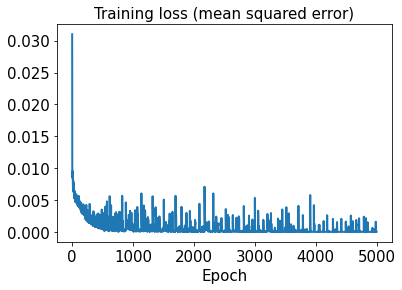

In [28]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

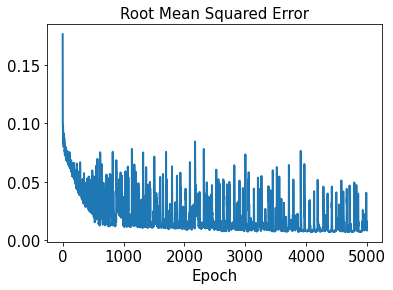

In [29]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [30]:
test_results = model.evaluate([x_train,aa_train])

47/47 [==============================] - 0s 2ms/step - loss: 1.0252e-05 - rmse: 0.0000e+00


In [31]:
decoded_train = model.predict([x_train,aa_train])

47/47 [==============================] - 0s 2ms/step


In [32]:
decoded_test = model.predict([x_test, aa_test])

20/20 [==============================] - 0s 2ms/step


In [33]:
error_train_abs = np.abs(decoded_train - y_train)

In [34]:
error_test_abs = np.abs(decoded_test - y_test)

In [35]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [36]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [37]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [38]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [39]:
decoded_train.shape

(1488, 2, 1)

In [40]:
os.chdir("D:\\TrainedModels\\20220929")
model.save('AeroCNN-I_5FClayer.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [41]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.023182206846586513


In [42]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.17923716283253058


In [43]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.02255359471365079


In [44]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.036304253067285734


In [45]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.17500435830089991


In [46]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.2624454816071209


In [47]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.01513496858437115, 0.009649082160565018, 0.013503063818323505, 0.06826605390777642, 0.01871118234260938, 0.01557671145114504, 0.007736342093549775, 0.007804635212056187, 0.0038486055302535058, 0.006241235968561838, 0.0017398193402299387, 0.008271883005088134, 0.0005349763280827649, 0.0039555900278296086, 0.002068943868661352, 0.005150753908930972, 0.009296610054819573, 0.003976031387417784, 0.003003501759038106, 0.007431702314488269, 0.021675234892354303, 0.018859683192781123, 0.008602862257057848, 0.016714630606882643, 0.004264141323556711, 0.002913075518730429, 0.0008100282737101135, 0.00040236316338668947, 0.0029578081806975382, 0.0011782096948831128, 0.006682215247507001, 0.00663001993663305, 0.012557238487742749, 0.020238721827092986, 0.011663249493027567, 0.0194756457804454, 0.03330725027860514, 0.060663749892892894, 0.017757048837377234, 0.005872563541888687, 0.002885541223604135, 0.004148824924871253, 0.004285268063844335, 0.007142585164851678, 0.0251972680567656, 0.00392442

In [48]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.00445911989736708, 0.04574223233897057, 0.04401875435054639, 0.07961748598020314, 0.2799968080719539, 0.7136768072727184, 0.20558810301663413, 0.14511667132576148, 0.09633949443751405, 0.09380334149755488, 0.35022030719009634, 0.07813017475195676, 0.0973788170207702, 0.5573043501476614, 0.17473028518466732, 0.2566281114604273, 0.0983989158954112, 0.0748390555530648, 0.07941096534372986, 0.08355761947652207, 1.1108384690443773, 0.14314434083355324, 0.06193816594310789, 0.0864874009866722, 0.066925912258592, 0.07041846055019721, 0.07149410439442215, 0.09879421913837005, 0.09651261386719745, 0.04273496407068461, 0.26576034105811375, 0.30756550225083973, 0.07475677385207274, 0.1150054521645034, 0.060621172698348096, 0.010681037407801132, 0.10803512988629253, 0.4250879731883647, 0.1534725342459076, 0.11592932447300995, 0.11686914573055938, 0.06464635987071764, 0.45941120811748537, 0.06097412350736372, 0.05491108530906737, 0.3263871889478295, 0.014395650263656539, 0.0823037068617806, 0.08

In [49]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.015129064563054554, 0.0095623746068944, 0.01099864680183553, 0.06873957231894257, 0.014254005084543438, 0.015593677490613734, 0.007716611223469451, 0.007586566383370127, 0.0031788995866657054, 0.006209706464558116, 0.0017190656837865145, 0.007963922282139952, 0.00053456420355562, 0.003884965843267568, 0.0019453364350825895, 0.005117514585646708, 0.009301562257534852, 0.003667578257241558, 0.002998056500027883, 0.007364564369397112, 0.02206510107902716, 0.005767534996231637, 0.007914439895679947, 0.016586318129046596, 0.0027541534389744246, 0.002665370497186651, 0.0005710078139129509, 0.0004027785236638178, 0.002964671349197824, 3.105629566672279e-05, 0.0045894184719832976, 0.006643298979428833, 0.012886167914027144, 0.01954400145012449, 0.011354717770209436, 0.0194052730936943, 0.03313709910640521, 0.05622550185937003, 0.016588559559865497, 0.0007538164899930598, 0.0028860537764437057, 0.0030457570870364597, 0.0020908235675299964, 0.00013192235582666653, 0.02185499642446989, 0.00084

In [50]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.017889005340612843, 0.029510144329970556, 0.11819044389657653, 0.05895878887332894, 0.10447232945061768, 0.003431319358054004, 0.01862314712169875, 0.06671550780803963, 0.07943403855847347, 0.02155127860863664, 0.007497298983139223, 0.05097713638554504, 0.0006554429694113829, 0.01103558877125562, 0.008647894451254093, 0.007301591488163502, 0.006299455438227862, 0.04007251930374071, 0.005332302534430363, 0.018234463576548454, 0.00046474148796639284, 0.13611830414387324, 0.06516510913479442, 0.059056547239525796, 0.09879836735391445, 0.03285355235319394, 0.012887110613395512, 0.0002365549415498181, 0.001262623836459919, 0.013408388251302004, 0.043336931770735256, 0.005948225163800596, 0.0031636213522125336, 0.0367360784401542, 0.03518880924117033, 0.03674581286683753, 0.046186605052529736, 0.150952150157992, 0.1337284633319022, 0.18019102909162915, 0.0023786004377023447, 0.04555262715690125, 0.036538921220981554, 0.03226107441534356, 0.05108255941624778, 0.012343936771517718, 0.000717

In [51]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.004101739877171164, 0.0456023846145552, 0.043580618543880574, 0.07930291714217218, 0.2814534477026859, 0.7260862346628321, 0.2055692523140994, 0.1451702689126195, 0.096099729629993, 0.09213573936816616, 0.3557057721113349, 0.0800277110182354, 0.0993335765069956, 0.5612485618152742, 0.17530507484937896, 0.2685566529583244, 0.09839191216985907, 0.07487326045406634, 0.07932268040616627, 0.08332746137537252, 1.600544467856755, 0.14305490213441246, 0.06191978571308787, 0.08650999324857865, 0.06619512519645779, 0.06984504947807058, 0.07120702463254354, 0.09819279394734487, 0.09648616182463347, 0.01248415105746993, 0.267327395480862, 0.3319024284956468, 0.07662007446087683, 0.09169415941765527, 0.0572950812401368, 0.010513980077825688, 0.10850045504563713, 0.43188406072597946, 0.1533328899623954, 0.11574491572473793, 0.11691780510943149, 0.06369082169953093, 0.46095072071839915, 0.06034518955394962, 0.04448115786607107, 0.3284380639822409, 0.015173467595177762, 0.0782893759566371, 0.087941

In [52]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.008852558712045084, 0.05043604820915805, 0.0935882173861975, 0.15594476125587248, 0.005799259793769644, 0.2003660362920793, 0.2132968192525255, 0.09041303773375665, 0.19044213352567754, 0.26253108684933224, 0.03174559789330325, 0.02613261516961108, 0.06757188487731315, 0.517760905322569, 0.16984361007173618, 0.1583231624417082, 0.10470731880784642, 0.03301007528739747, 0.11983682310977554, 0.11994384614132364, 0.01875198542203634, 0.15699836512303775, 0.07291487227232862, 0.05076778871336916, 0.4100389345557443, 0.38075671229894514, 0.25225892511367254, 0.3383694774440773, 0.10557737976860475, 0.4125719262787997, 0.2253783108450031, 0.09594524252327585, 0.022026673237726016, 0.4554486857038724, 0.3087694463446769, 0.04170698316459018, 0.00916250976899942, 0.1972072732133345, 0.20242267572388853, 0.23280931385723494, 0.030201215791429304, 0.24073153676138143, 0.3213180989888617, 0.0720860889301061, 0.1323740467449842, 0.30179380999096, 0.002209048897044329, 0.10654347875995034, 0.074

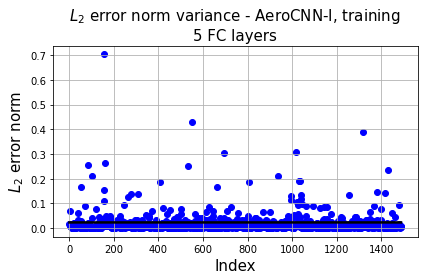

In [53]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, training\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

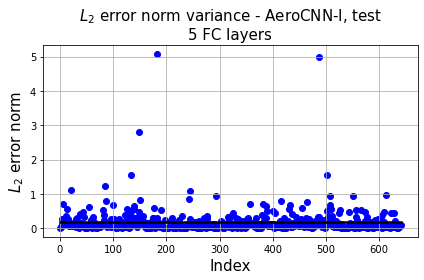

In [54]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, test\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

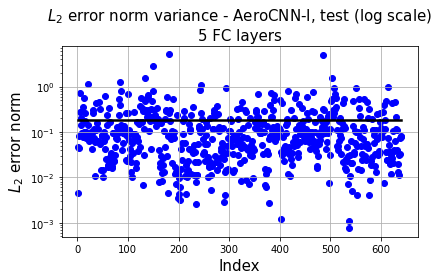

In [55]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, test (log scale)\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

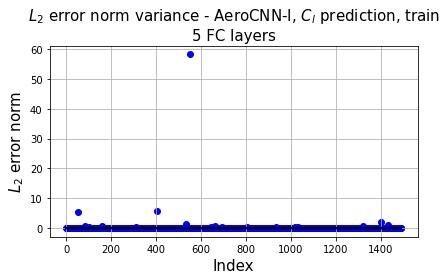

In [56]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

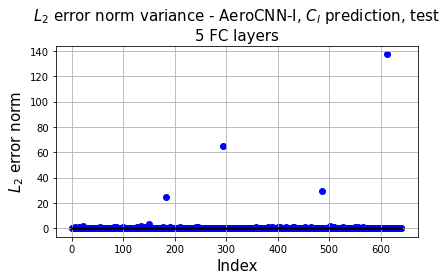

In [57]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

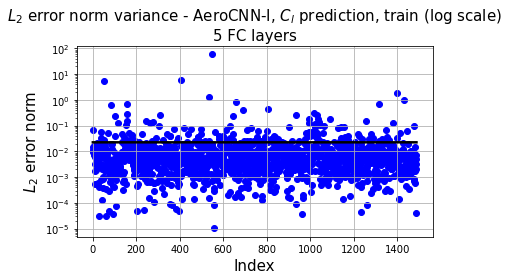

In [58]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train (log scale)\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

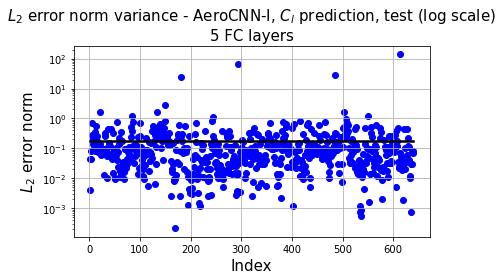

In [59]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test (log scale)\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

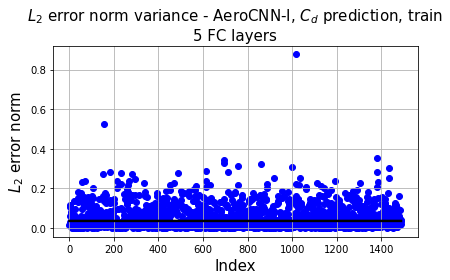

In [60]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, train\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

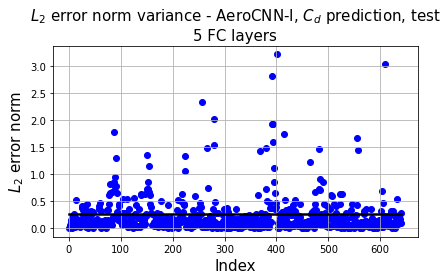

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, test\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

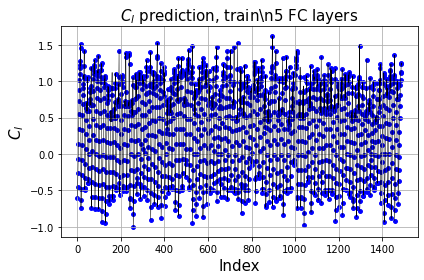

In [62]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

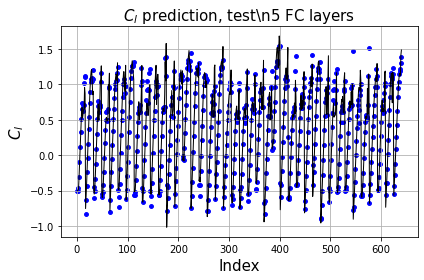

In [63]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

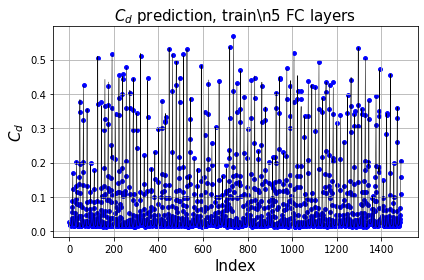

In [64]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

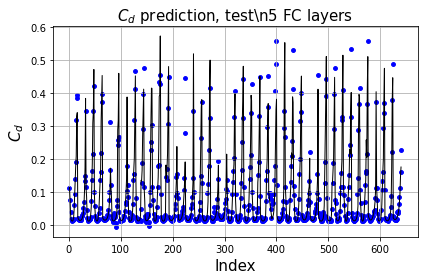

In [65]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test\n5 FC layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

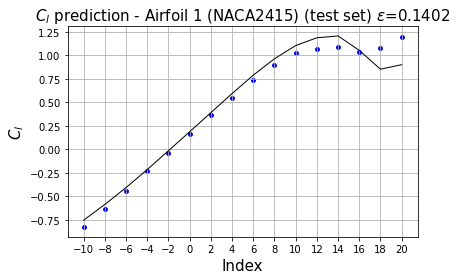

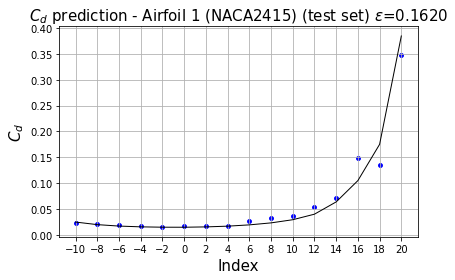

In [70]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

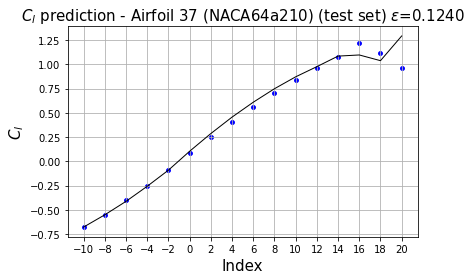

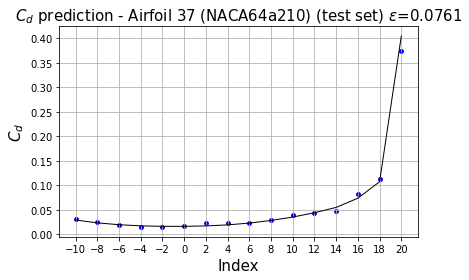

In [71]:
airfoiltest37_predict = decoded_test[16*36:16*37]

airfoiltest37_cl=y_test[16*36:16*37,0,:]
airfoiltest37_cd=y_test[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

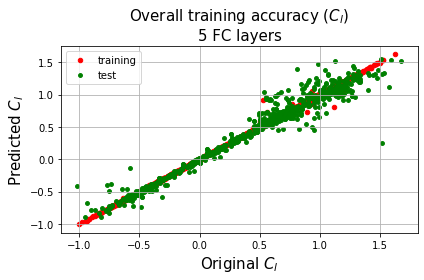

In [68]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n5 FC layers', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

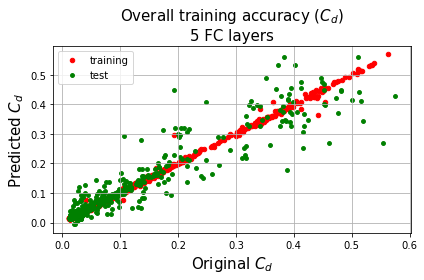

In [69]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n5 FC layers', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()